# Multirotor Reference Trajectory

## References
* Mellinger, Daniel Warren, "Trajectory Generation and Control for Quadrotors" (2012). Publicly Accessible Penn Dissertations. 547. (pg. 16)

## Notation

We will use a notation where $\hat{x}^b_e$ is the x unit vector of frame b expressed in component of frame e, $\vec{v}_b$ is a vector v expressed in components of frame b, and $\vec{\omega}^{eb}_b$ is the angular velocity of frame b with respect to frame, expressed in components of frame b. If not coordinate frame is indicated, it indicates the general vector that can be expressed in any frame. The rotation matrix $C^e_b$ operates on vectors such that $\vec{v}_b = C^e_b \vec{v}_e$. This convention let's us be very specific about the coordinate frame each vector is expressed in when necessary.


## Problem Statement

To simplify planning, we will leverage the differential flatness of the multirotor to solve for the states and inputs as a fucntion of the flat outputs and their derivatives.


### Flat Outputs:
* $\vec{p}_e$ : the position of the multirotor expressed in the e frame
* $\psi$ : the desired yaw angle

### Flat Output Derivatives:
* $\vec{v}_e$ : the velocity of the multirotor expressed in the e frame
* $\vec{a}_e$ : the acceleration of the multirotor expressed in the e frame
* $\vec{j}_e$ : the jerk of the multirotor expressed in the e frame
* $\vec{s}_e$ : the snap of the multirotor expressed in the e frame
* $\dot{\psi}$, $\ddot{\psi}$, $\ldots{}$ : derivatives of the yaw angle
* higher derivatives if necessary

### States
* $\vec{p}_e$ : the position of the multirotor expressed in the e frame
* $\vec{v}_b$ : the velocity of the multirotor wrt the e frame expressed in the b frame
* $C^b_e$ : the direction cosine matrix, element of $SO(3)$, of the states wrt to the b frame, can be parameterized with Euler angles, quaternions, etc.
* $\vec{\omega}^{eb}_b$ : the angular velocity of body frame wrt the e frame expressed in the b frame

## Inputs:
* T : The thrust
* $\vec{M}_b$ : the control moment of the quadrotor due to the motors expressed in the b (body) frame

### Frames

**Note we deviate from Mellginer's convention and use the North-East-Down instead of East-North-Up frame to follow aeronautical convention.**

* e : earth/world frame, inertial frame, (North-East-Down)
* c : camera frame, rotated from earth frame by: $\psi \hat{e}^z$
* b : body frame, fixed in multirotor, (Forward-Right-Down)

Constants:
* m : mass of multirotor
* g : acceleration of gravity



## Solve for $C^b_e$


From Newton's 2nd Law:

$$m\vec{a} = -T \hat{z}^b + m g \hat{z}^e$$
Note $\hat{z}^w$ is the down direction in the earth frame and $\hat{z}^b$ is the down direction in the body-fixed frame.

Solving for Thrust (T):

$$T \hat{z}^b = m(\vec{a} +  g \hat{z}^e)$$

We can now solve for $\hat{z}^b$ and T:

$$\vec{t}_e \equiv m(\vec{a}_e -  g \hat{z}^e_e)$$

$$T = ||\vec{t}_e||$$

$$\hat{z}^b_e = \dfrac{\vec{t_e}}{T}$$

This will result in a singularity if $T = 0$.


We wish to specify the yaw angle $\psi$, and can do so by computing the body unit vector $\hat{y}^b$ as follows:

$$\vec{x}^c_e = \begin{bmatrix} \cos{\psi} & \sin{\psi} & 0 \end{bmatrix}^T$$

$$\hat{y}^b_e = \dfrac{\hat{z}^b_e \times \hat{x}^c_e}{||\hat{z}^b_e \times \hat{x}^c_e||}$$
This will result in a singularity if $\hat{z}^b_e$ is aligned with $\hat{x}^c_e$.

We can solve for $\hat{x}^b_e$ using the cross product of unit vectors:

$$\hat{x}^b_e = \hat{y}^b_e \times \hat{z}^b_e$$

Finally, we can construct $C^b_e$ using the unit vectors:

$$C^b_e = \begin{bmatrix} \hat{x}^b_e & \hat{y}^b_e & \hat{z}^b_e \end{bmatrix}$$


In [1]:
%load_ext autoreload
%autoreload 2

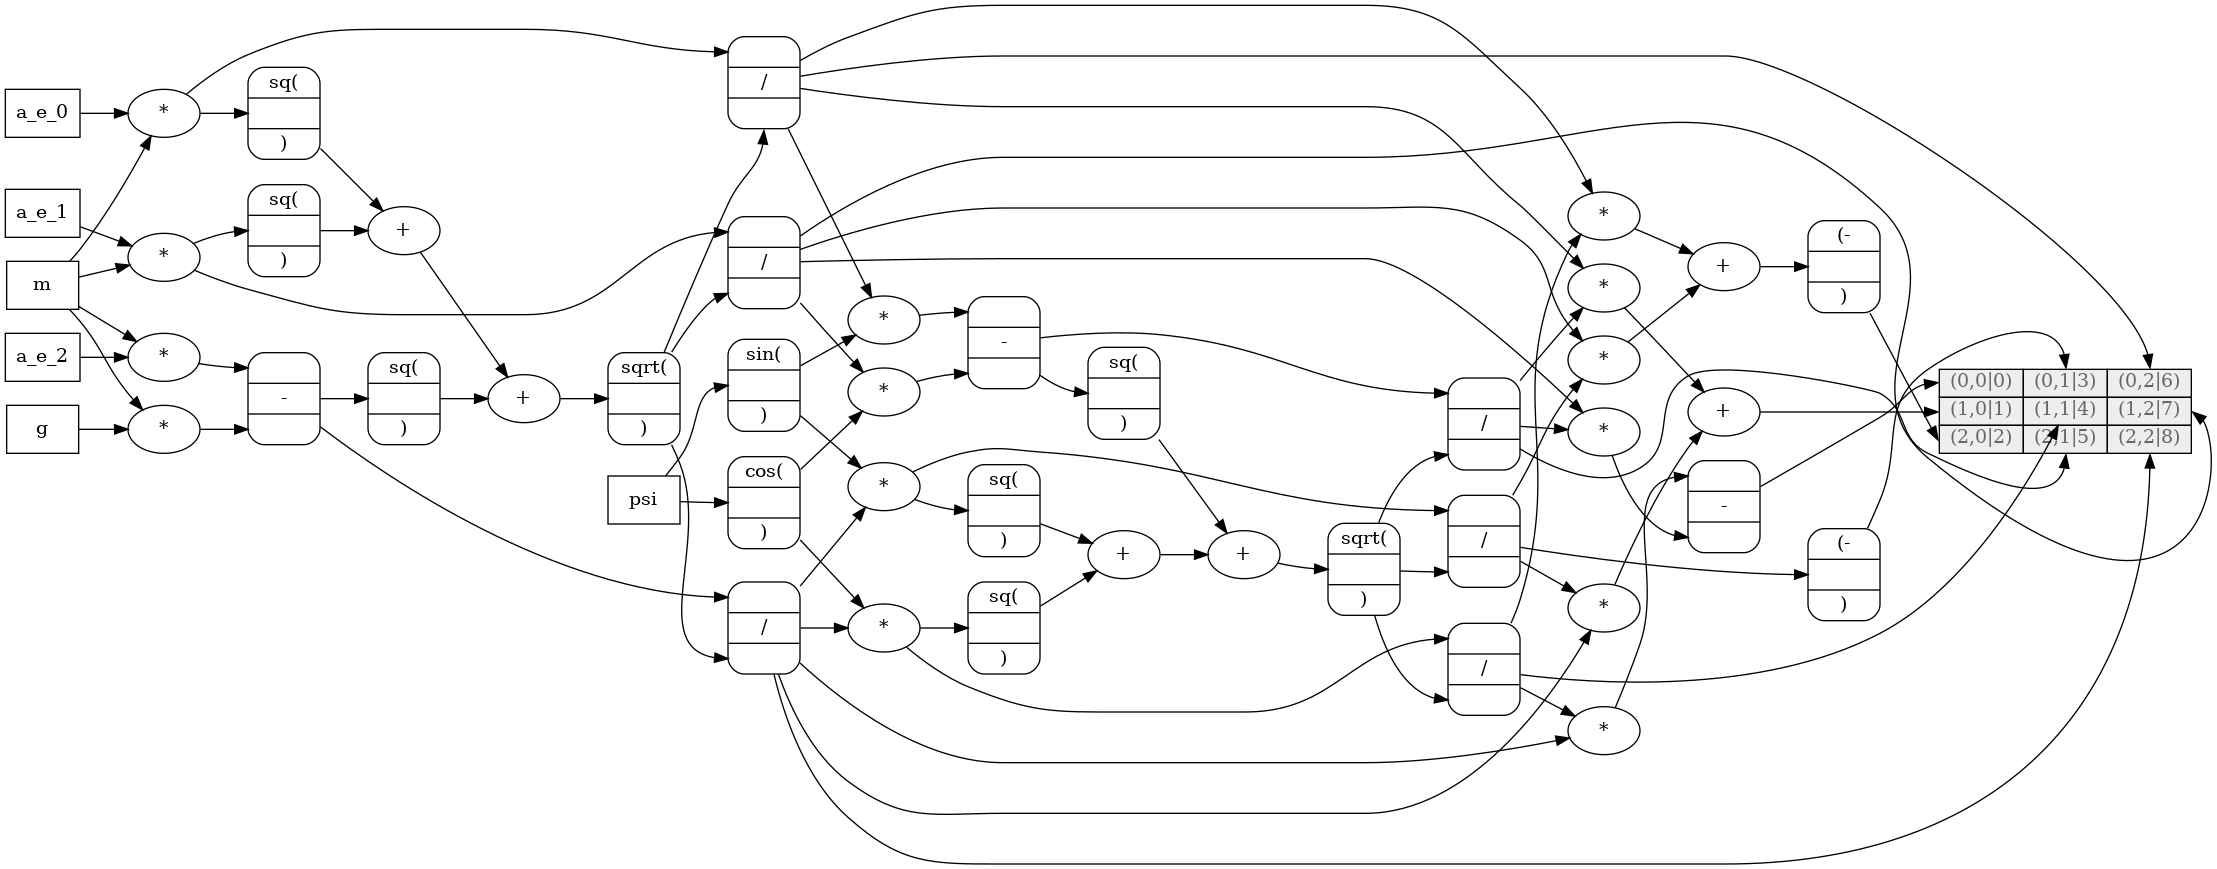

In [2]:
from casadi_graph_fix import dotdraw
import casadi as ca

# flat output (input variables from trajectory planner)
a_e = ca.SX.sym('a_e', 3)  # accel
j_e = ca.SX.sym('j_e', 3)  # jerk
s_e = ca.SX.sym('s_e', 3)  # snap

psi = ca.SX.sym('psi')  # desired heading direction
psi_dot = ca.SX.sym('psi_dot')  # derivative of desired heading

# constants
m = ca.SX.sym('m')  # mass
g = ca.SX.sym('g')  # accel of gravity
xh = ca.SX([1, 0, 0])
yh = ca.SX([0, 1, 0])
zh = ca.SX([0, 0, 1])

# acceleration
thrust_e = m*a_e - m*g*zh

T = ca.norm_2(thrust_e)
zb_e = thrust_e/T  # can have singularity when T = 0

# desired heading direction
xc_e = ca.cos(psi)*xh + ca.sin(psi)*yh

yb_e = ca.cross(zb_e, xc_e)
yb_e = yb_e/ca.norm_2(yb_e)  # normalize y_b, can have singularity when z_b and x_c aligned
xb_e = ca.cross(yb_e, zb_e)

#T_dot = ca.dot(m*s_e, zb_e)
C_be = ca.hcat([xb_e, yb_e, zb_e])

dotdraw(C_be)

## Solve for $\vec{\omega}^{eb}_b$

First we solve for $r(q, \dot{\psi}, \phi, \theta)$.

In [3]:
def r_solve():
    """Solves for r given psi_dot, phi_dot

    Returns:
        smpy expression: solution of r
    """
    import sympy
    import sympy.physics.mechanics as mech
    t = sympy.symbols('t')
    mech.init_vprinting()
    frame_e = mech.ReferenceFrame('e')
    psi, theta, phi = mech.dynamicsymbols('psi, theta, phi')
    p, q, r = mech.dynamicsymbols('p, q, r')
    frame_b = frame_e.orientnew('b', 'Body', (psi, theta, phi), '321')
    omega_eb_b = p*frame_b.x + q*frame_b.y + r*frame_b.z
    sol = sympy.solve((frame_b.ang_vel_in(frame_e) - omega_eb_b).to_matrix(frame_b), [p, q, r])
    sol2 = sympy.solve([
        p - sol[p],
        q - sol[q],
        r - sol[r]
    ], [r, theta.diff(t), phi.diff(t)], simplify=True)
    return sympy.Eq(r, sol2[r])
    
r_solve()

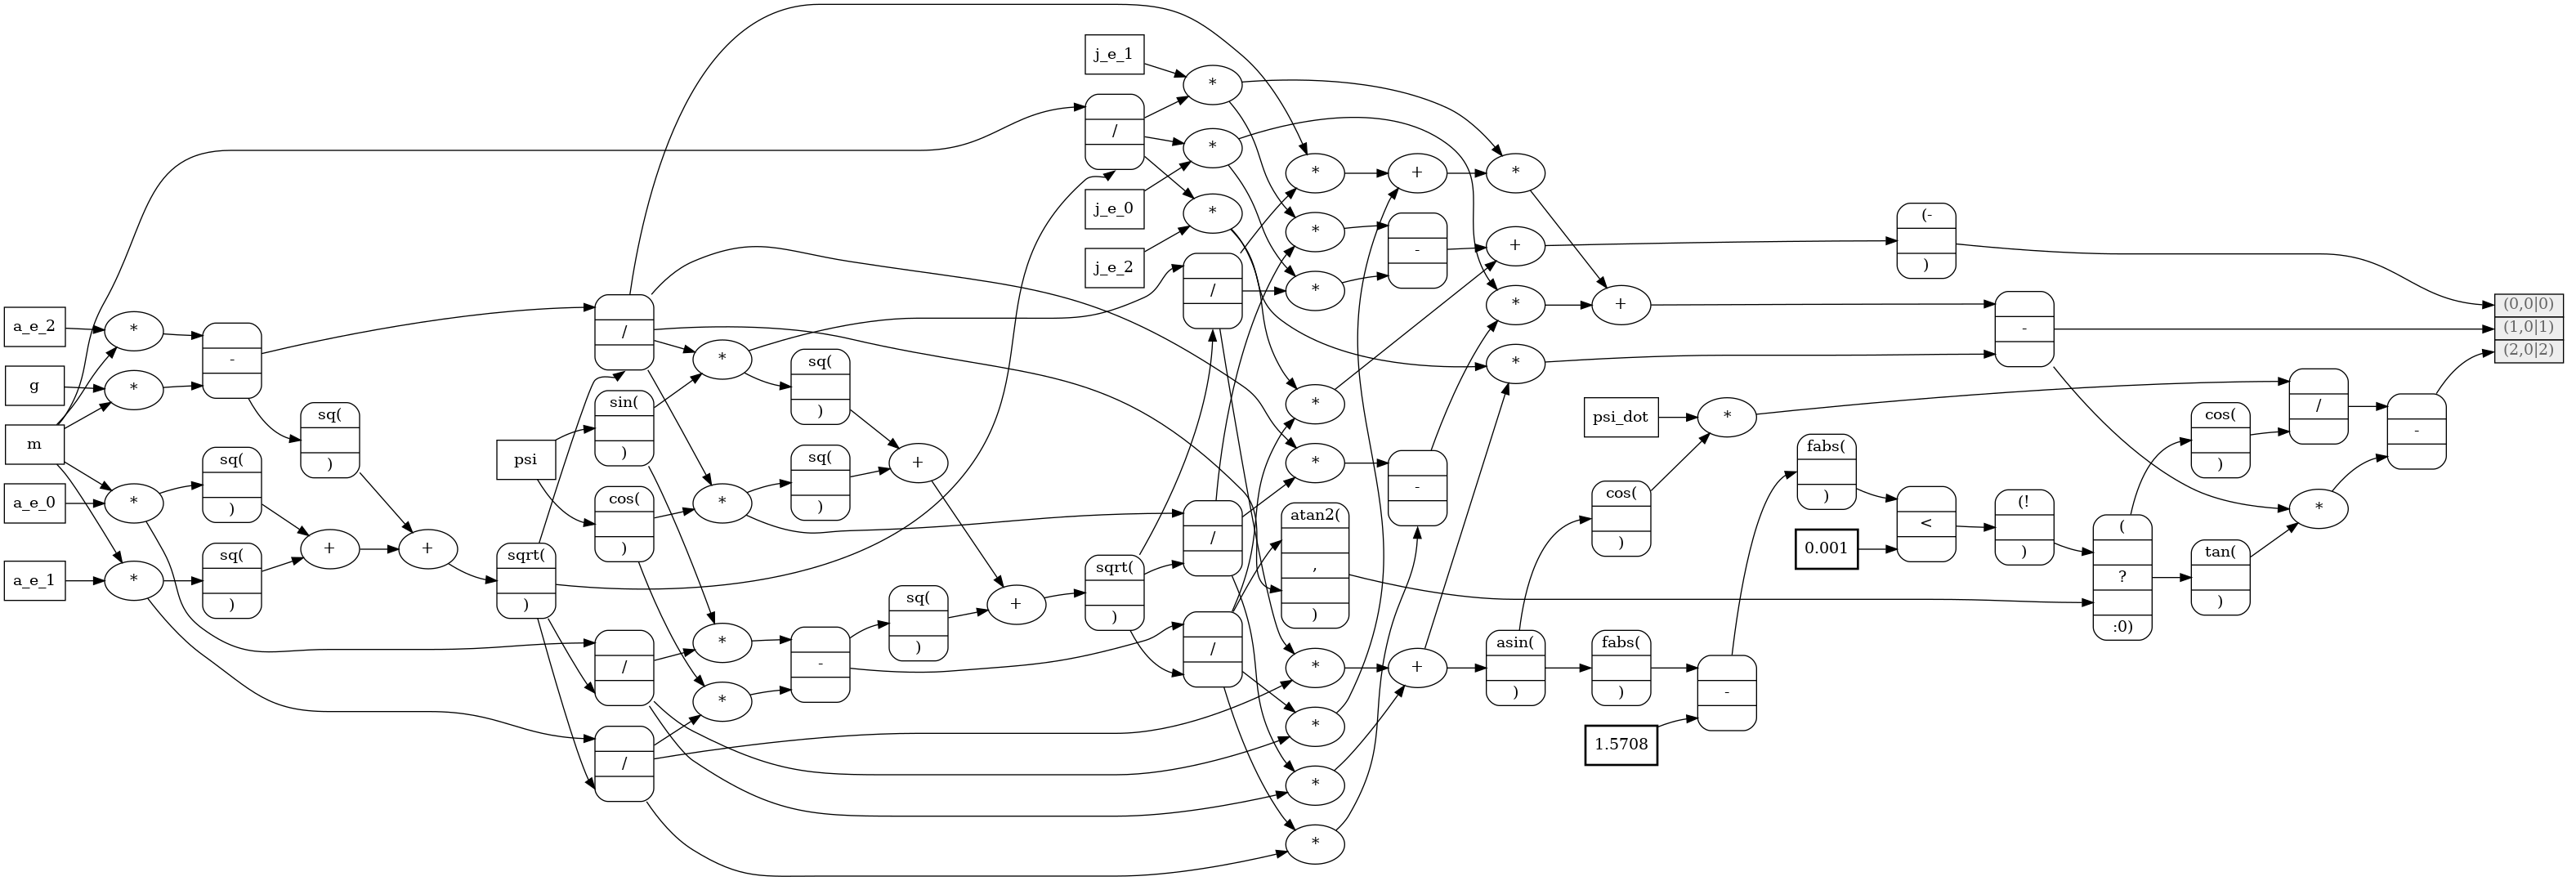

In [4]:
# note h_omega z_b component can be ignored with dot product below
t2_e = m/T*j_e
p = -ca.dot(t2_e, yb_e)
q = ca.dot(t2_e, xb_e)

# solve for euler angles based on DCM
theta = ca.asin(-C_be[2, 0])
phi = ca.if_else(
    ca.fabs(ca.fabs(theta) - ca.pi/2) < 1e-3,
    0,
    ca.atan2(C_be[2, 1], C_be[2, 2])
)

# sole for r
r = -q*ca.tan(phi) + ca.cos(theta)*psi_dot/ca.cos(phi)  # from R_solve below, singularity at phi=pi

omega_eb_b = p*xh + q*yh + r*zh

dotdraw(omega_eb_b)

In [5]:
# create function
f_ref = ca.Function('f_ref',
    [psi, psi_dot, a_e, j_e, m, g], [C_be, omega_eb_b],
    ['psi', 'psi_dot', 'a_e', 'j_e', 'm', 'g'],
    ['C_be', 'omega_eb_b']
    )
res = f_ref(1, 0, [1, 1, 1], [1, 1, 1], 1, 9.8)
res

(DM(
 [[0.529308, 0.840979, 0.112197], 
  [0.834162, -0.539986, 0.112197], 
  [0.15494, 0.0342037, -0.987332]]),
 DM([-0.0376079, 0.170361, 0.00590173]))

In [6]:
# c code generation
generator = ca.CodeGenerator('gen')
generator.add(f_ref)
generator.generate()

'gen.c'

In [7]:
%%timeit
res = f_ref(1, 0, [1, 2, 3], [1, 1, 1], 1, 9.8,)

16.9 µs ± 82.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
